In [1]:
#1. 필요 라이브러리 설치
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.4/532.4 kB 12.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 필요 라이브러리 설치(2)

import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

In [3]:
# 데이터 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 이미지를 -1에서 1 사이의 값으로 정규화
])

# 기본 FashionMNIST 데이터셋 로드
original_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
original_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 데이터셋의 길이 확인
print("Original train dataset length:", len(original_train_dataset))
print("Original test dataset length:", len(original_test_dataset))

# 새로운 학습용 및 테스트용 데이터셋 생성
new_train_dataset = torch.utils.data.Subset(original_train_dataset, range(25000))
new_test_dataset = torch.utils.data.Subset(original_test_dataset, range(10000))

# 새로운 데이터셋의 길이 확인
print("New train dataset length:", len(new_train_dataset))
print("New test dataset length:", len(new_test_dataset))


100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Original train dataset length: 60000
Original test dataset length: 10000
New train dataset length: 25000
New test dataset length: 10000


Label: 9


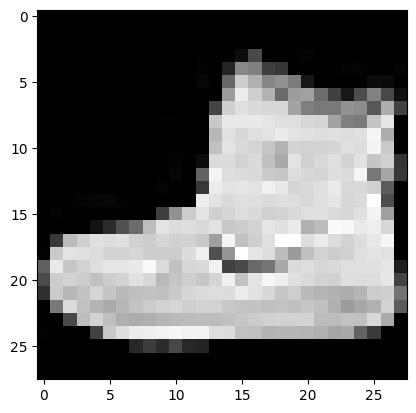

In [4]:
# 훈련 데이터의 첫 번째 이미지와 레이블 확인
image, label = new_train_dataset[0]
print("Label:", label)
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 추출하여 이미지 클래스 정의
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

# 이미지 시각화 함수 정의
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
# 컨볼루션 신경망(CNN)을 사용하여 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
# 모델 생성
model = CNN()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 손실 값을 기록하는 리스트 정의
losses = []

# 훈련 데이터를 로드하는 DataLoader 정의
batch_size = 64  # 배치 크기 설정
trainloader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=True)



In [19]:
# 모델 훈련
for epoch in range(11):  
    # 에폭 수 설정: 초기 실험 결과 loss 손실 함수 값이 에폭이 11일 때, 
    # loss:0.148로 적절하고, 그래프상에서도 손실 함수를 유지하며 가능한 수평을 유지하기 위해 적절한 에폭 값으로 11을 설정
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:  # 매 200 미니배치마다 출력: 에폭과 매 200 미니배치에 따른 loss 손실 함수 값을 확인하여 적절한 에폭 값 확인
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 200:.3f}")
            losses.append(running_loss / 200)
            running_loss = 0.0

print("Finished Training")

[Epoch 1, Batch 200] loss: 0.753
[Epoch 2, Batch 200] loss: 0.408
[Epoch 3, Batch 200] loss: 0.334
[Epoch 4, Batch 200] loss: 0.289
[Epoch 5, Batch 200] loss: 0.263
[Epoch 6, Batch 200] loss: 0.234
[Epoch 7, Batch 200] loss: 0.213
[Epoch 8, Batch 200] loss: 0.187
[Epoch 9, Batch 200] loss: 0.167
[Epoch 10, Batch 200] loss: 0.156
[Epoch 11, Batch 200] loss: 0.134
Finished Training


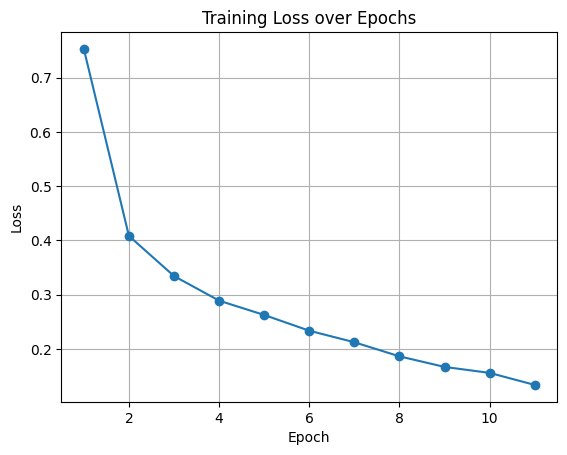

In [20]:
# 에폭별 손실값 시각화
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

In [21]:
# 모델 테스트
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the network on the test images: {accuracy:.2f}%")
# test image의 정확성 출력: 실험의 test images의 정확성은 89.78%이다.

Accuracy of the network on the test images: 89.78%


In [11]:
# 잘못 분류된 이미지 확인
model.eval()
misclassified_images = []
predicted_labels = []
true_labels = []

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        misclassified_mask = predicted != labels
        misclassified_images.extend(inputs[misclassified_mask])
        predicted_labels.extend(predicted[misclassified_mask])
        true_labels.extend(labels[misclassified_mask])


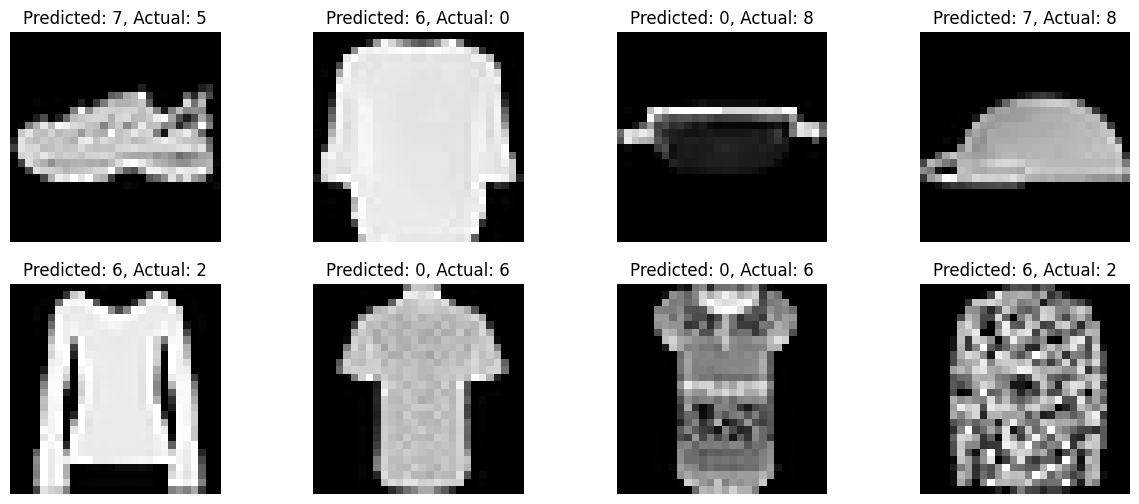

In [12]:
# 잘못 분류된 이미지 및 예측과 실제 레이블 시각화 (최대 8개 이미지)
num_images = len(misclassified_images)
num_display = min(num_images, 8)  # 8개의 잘못 예측된 이미지를 표시

plt.figure(figsize=(15, 6))
for i in range(num_display):
    plt.subplot(2, 4, i + 1)
    plt.imshow(misclassified_images[i].squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_labels[i]}, Actual: {true_labels[i]}")
    plt.axis('off')

plt.show()

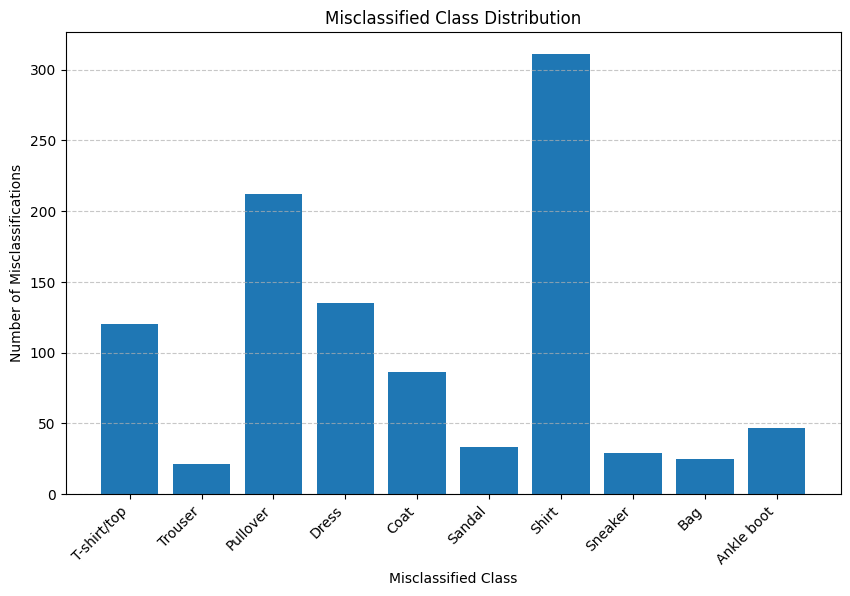

Total misclassified images: 1019 / 10000 (test data)
The most misclassified clothing class: Shirt (311 misclassifications)


In [13]:
# 잘못 분류된 클래스별 분포 시각화
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
misclassified_class_count = {class_name: 0 for class_name in classes}

for true_label, predicted_label in zip(true_labels, predicted_labels):
    true_class = classes[true_label]
    predicted_class = classes[predicted_label]
    if true_class != predicted_class:
        misclassified_class_count[true_class] += 1

# 막대그래프를 통해 예측에 실패한 Class Image 확인
plt.figure(figsize=(10, 6))
plt.bar(misclassified_class_count.keys(), misclassified_class_count.values())
plt.xlabel('Misclassified Class')
plt.ylabel('Number of Misclassifications')
plt.title('Misclassified Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# test data에서 예측 실패한 image 개수 구하기 
total_misclassified = sum(misclassified_class_count.values())
total_test_images = len(new_test_dataset)
misclassification_ratio = total_misclassified / total_test_images

# 위 주석문에 따른 출력문 : 10,000개의 test image중에서 1,019개의 이미지를 예측 실패했다.
print(f"Total misclassified images: {total_misclassified} / {total_test_images} (test data)")

# 예측에 가장 많이 실패한 Class Clothes 구하기
max_misclassified_class = max(misclassified_class_count, key=misclassified_class_count.get)
max_misclassified_count = misclassified_class_count[max_misclassified_class]

# 위 주석문에 따른 출력문 : shirts로 311개의 데이터가 예측 실패했다.
print(f"The most misclassified clothing class: {max_misclassified_class} ({max_misclassified_count} misclassifications)")